# Assignment 3: Linear Regression

Only use the already imported library `numpy` and the Python standard library. Make sure that the datasets `dataLinReg2D.txt`, `dataQuadReg2D.txt`, `dataQuadReg2D_noisy.txt` and `airfoil_self_noise.dat` are in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

Jonas Lammert 3149269

Alexander Tiessen 2965198

Patrick Schneefuss 2951267

## Task 1: Ridge Regression for Polynomial 2D Functions

Each line in the data sets consists of a data entry `(x,y)` with a 2D point `x` and a 1D function output `y`.

In [171]:
# Load required packages and datasets. Do not modify.
import numpy as np


def load_dataset(path):
    data = np.loadtxt(path)
    X, y = data[:, :2], data[:, 2]
    
    return X, y
    

X_lin, y_lin = load_dataset("dataLinReg2D.txt")
X_quad, y_quad = load_dataset("dataQuadReg2D.txt")
X_noise, y_noise = load_dataset("dataQuadReg2D_noisy.txt")

1) Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`). You may also experiment with other feature transformations, e.g. third-order polynomials.

In [172]:
def make_features(X, ftype='lin'):
    n, d = X.shape
    
    if ftype == 'lin': # Linear feature transformation (including intercept)
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:] = X
        
    elif ftype == 'quad':  # Quadratic feature transformation
                    
        Phi = np.empty((n, 1+d + int((d*(d+1))/2)))
        Phi[:, 0] = 1
        Phi[:, 1:d+1] = X
        index = d+1
        for i in range(0,d):
            for j in range(i,d):
                Phi[:, index + (j-i)] = X[:, i] * X[:, j]
            index += d-i    

        
    
    elif ftype == 'nasa':
        # Implement for task 2.2.
        
        Phi = make_features(X, ftype='quad')
        
        columns = np.empty((Phi.shape[0], Phi.shape[1] + 1))
        columns[:, 0] = Phi[:,0]
        columns[:, 1] = Phi[:,1]
        columns[:, 2] = np.cos(Phi[:,2] * np.pi / 180)
        columns[:, 3] = np.sin(Phi[:,2] * np.pi / 180)
        columns[:, 4:] = Phi[:,3:]        

        Phi = columns


    
    else:
        raise Exception('Feature type {} not implemented yet'.format(ftype))
    
    return Phi

2) Implement Ridge Regression to fit a polynomial function to the data sets with the regularization parameter `lambda_` and feature type `ftype`.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`.

In [173]:
# Implement your solution here.
class RidgeRegression(object):
    def __init__(self, lambda_, ftype = 'lin'):
        self.lambda_ = lambda_
        self.ftype = ftype
        self.beta = None  # Learned regression coefficients.
    
    def fit(self, X, y):
        """
        X is an array of shape (n, d), 
            where n is the number of samples and d is the number of features.        y is an array of shape (n,)
        """

        Phi = make_features(X, self.ftype)       

        # see slide-set regression-part2 slide 31
        self.beta = np.linalg.inv(Phi.T.dot(Phi) + self.lambda_ * np.eye(Phi.shape[1])).dot(Phi.T.dot(y))
        
        
        
        
    
    def predict(self, X):
        """
        X is an array with shape (n, d).
        The method returns an array of shape (n,).
        """
        Phi = make_features(X, self.ftype)

        return Phi.dot(self.beta)
        
        
    

3) Implement the function `MSE` to compute the mean squared error. `y_pred` and `y_true` are the vectors of predicted and true function outputs respectively with shape `(n,)`, where `n` is the number of samples. The function returns a single float.

In [174]:
def MSE(y_pred, y_true):
    # Implement your solution here.
    return (np.square(y_pred - y_true)).mean(axis=None)
    

4) Evaluate your Ridge Regression model with linear features on the linear `(X_lin, y_lin)` data set. Try to find a good `lambda_`. How does it perform with quadratic features on this data set? Report the MSE on the full data set when trained on the full data set. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

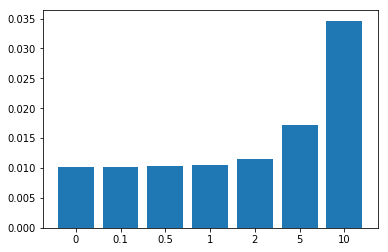

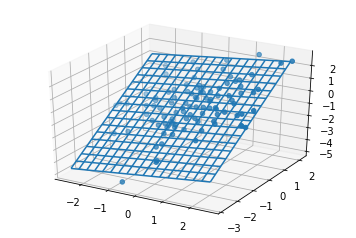

In [175]:
def train_evaluate(regression_model, X, y):
    regression_model.fit(X, y)
    yhat = regression_model.predict(X)    
    #print('MSE:', MSE(yhat, y))
    return MSE(yhat,y)

    
def plot_data_and_model(regression_model, X, y):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.axes3d import Axes3D
    %matplotlib inline
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker = 'o')
    
    xmin = X.min(0)
    xmax = X.max(0)

    x0grid, x1grid = np.mgrid[xmin[0]:xmax[0]:.3, xmin[1]:xmax[1]:.3]

    xdim0, xdim1 = np.shape(x0grid)
    xsize = np.size(x0grid)

    x0hat = x0grid.flatten()
    x1hat = x1grid.flatten()
    x0hat = x0hat.reshape((np.size(x0hat), 1))
    x1hat = x1hat.reshape((np.size(x1hat), 1))
    xhat = np.append(x0hat, x1hat, 1)
    xhatfv = make_features(xhat, regression_model.ftype)
    yhat = xhatfv.dot(regression_model.beta)
    ygrid = yhat.reshape((xdim0, xdim1))
    ax.plot_wireframe(x0grid, x1grid, ygrid)
    ax.auto_scale_xyz([xmin[0], xmax[0]], [xmin[1], xmax[1]], [y.min(), y.max()])
    fig.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline    
# Implement your solution here.
mse = []
lmbdas = [0, 0.1, 0.5, 1, 2 , 5, 10]
for lmbda in lmbdas:
    regression_lin = RidgeRegression(lmbda, ftype='lin')
    mse.append(train_evaluate(regression_lin, X_lin, y_lin))
    
    
fig = plt.figure()
x_pos = [i for i, _ in enumerate(lmbdas)]
plt.bar(x_pos, mse)
plt.xticks(x_pos, lmbdas)
plt.show()

# If the plot doesn't show the first time, run this cell again
plot_data_and_model(regression_lin, X_lin, y_lin)

For lambda-values close to zero (-1 to 1) the mse stays very similar at around 0.01. The more lambda moves away from zero, the higher the MSE gets. 
The model has been trained on the whole data-set and thus is fitted for it. Consequently, by adding more bias (moving lambda away from zero) the model performs worse for the data used for
training, but is supposed to show less variance when predicting on a set different from the training set.

5) Try to find a good model (including features and suitable `lambda_` parameters) for the quadratic data set `(X_quad, y_quad)`. Report the MSE on the full data set when trained on the full data set.  (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.) Also plot your predicted model using the method above `plot_data_and_model`.

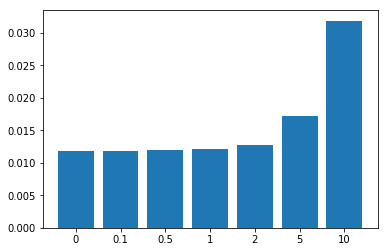

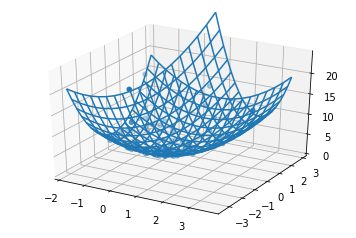

In [176]:
# Implement your model tests here using the quadratic data set
mse = []
for lmbda in lmbdas:
    regression_quad = RidgeRegression(lmbda, ftype='quad')
    mse.append(train_evaluate(regression_quad, X_quad, y_quad))

fig = plt.figure()
x_pos = [i for i, _ in enumerate(lmbdas)]
plt.bar(x_pos, mse)
plt.xticks(x_pos, lmbdas)
plt.show()

plot_data_and_model(regression_quad, X_quad, y_quad)

The same pattern as in 4 applies. The further we move lambda away from zero, the higher the MSE gets. However for quadratic features, the MSE for all lambda values is slightly higher than for linear features, so most likely the quadratic model is seeing a quadratic relationship between the independent variables where in reality is no such relationship.

6) Try to find a good model (including features and suitable `lambda_` parameters) for the noisy data set `(X_noise, y_noise)`. Report the MSE on the full data set when trained on the full data set.  (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.) Also plot your predicted model using the method above `plot_data_and_model`.

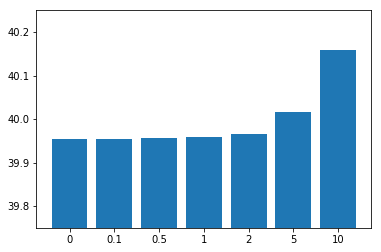

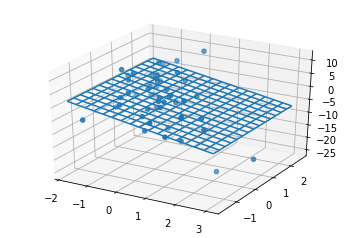

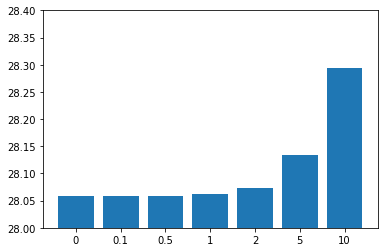

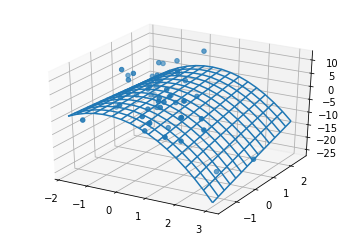

In [177]:
# Implement your model tests here using the noisy data set
mse = []
for lmbda in lmbdas:
    regression_lin = RidgeRegression(lmbda, ftype='lin')
    mse.append(train_evaluate(regression_lin, X_noise, y_noise))

fig = plt.figure()

x_pos = [i for i, _ in enumerate(lmbdas)]
plt.bar(x_pos, mse)
plt.ylim(39.75,40.25)
plt.xticks(x_pos, lmbdas)
plt.show()

plot_data_and_model(regression_lin, X_noise, y_noise)

mse = []
for lmbda in lmbdas:
    regression_quad = RidgeRegression(lmbda, ftype='quad')
    mse.append(train_evaluate(regression_quad, X_noise, y_noise))

fig = plt.figure()

x_pos = [i for i, _ in enumerate(lmbdas)]
plt.bar(x_pos, mse)
plt.ylim(28,28.4)
plt.xticks(x_pos, lmbdas)
plt.show()

plot_data_and_model(regression_quad, X_noise, y_noise)

Again, the closer lambda is to 0, the lower the MSE. The explanation for this is analogous to the previous sections. However in the noisy dataset, the quadratic model show a lower MSE compared to the linear model (MSE ~40 for linear, ~28 for quadratic). This leads to the assumption, that there is a quadratic relationship between the input-features of this dataset.
Obviously, the MSE for both models is higher than the MSE for the previous datasets as there is a lot more noise in this set.

## Task 2: Airfoil Self-Noise Prediction

The air self-noise dataset is a [dataset by NASA](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise). Your task is to find a good feature mapping for ridge regression to achieve the lowest possible prediction error.

1) Explain the content of the dataset in few words. What are the input features? What is the output?

The NASA data set comprises different size airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

Input:
* frequency [Hertzs]
* angle_of_attack [degrees]
* Chord length [meters]
* free_stream_velocity [meters/second]
* suction_side_displacement_thickness [meters]

The _output_ is the sound pressure level [decibels] (last value in dataset).


In [178]:
def load_dataset(path):
    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    
    return X, y
    

X, y = load_dataset('airfoil_self_noise.sec')

2) Implement the option `ftype = 'nasa'` in the `make_features` function. You should try any type of non-linear features and interactions between features. You are not restricted to the feature mapping presented in the lecture. It is helpful to think about the domain and characteristics of the features, e.g. how do you work with periodic features.

Explain the choice of your features:

For the features in Task 3, we chose to go with quadratic features as the baseline and then replace each value v in a column of a periodic feature by two values in two new colums with sin(v) and cos(v) after normalising to radians. For example this solves the problem, that for angles normally the values 1 and 359 are treated as very far apart, when in reality they are only 2 degrees apart.

3) Evaluate your Ridge Regression model with your chosen features on the data set. Try to find a good `lambda_`. Report the MSE on the full data set when trained on the full data set. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

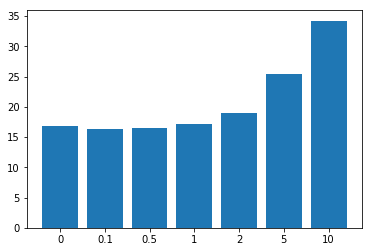

In [179]:
def train_evaluate(regression_model, X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    regression_model.fit(X_train, y_train)
    yhat_test = regression_model.predict(X_test)
    #print('MSE:', MSE(yhat_test, y_test))
    return MSE(yhat_test, y_test)

lmbda = [0, 0.1, 0.5, 1, 2, 5, 10]
mse = []
for l in lmbda:

    your_regression = RidgeRegression(lambda_=l, ftype='nasa')
    mse.append(train_evaluate(your_regression, X, y))

fig = plt.figure()

x_pos = [i for i, _ in enumerate(lmbda)]
plt.bar(x_pos, mse)

plt.xticks(x_pos, lmbda)
plt.show()



The MSE for different lambda-values are displayed in the bar-plot above. Again, a low lambda value yields a lower MSE with lambda = 0 providing the best results. This is a little bit strange, since the line was not fitted for the testing data used in this task, so one would think slightly shifting the function would improve the MSE.

**For all students other than B.Sc. Data Science:**

4) Implement the function `cross_validation` to evaluate the prediction error of your model. Report the mean squared error from cross-validation. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

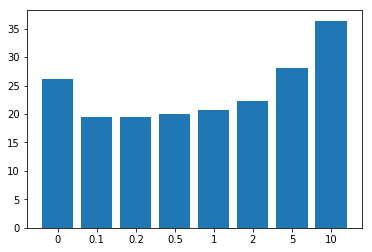

In [180]:
def cross_validation(regression_model, X, y): 

    
    a = np.column_stack((X,y))
    
    folds = np.array_split(a, 5)    
    fold_indices = [0,1,2,3,4]    
    mse = []
    for p in fold_indices:        
        
        X_train = np.concatenate([folds[x][:,:-1] for i,x in enumerate(fold_indices) if i != p ])        
        y_train = np.concatenate([folds[x][:,-1] for i,x in enumerate(fold_indices) if i != p ])
        X_test = folds[i][:,:5]
        y_test = folds[i][:,5]

        regression_model.fit(X_train, y_train)
        yhat_test = regression_model.predict(X_test)
        mse.append(MSE(yhat_test, y_test)) 


    return np.average(mse)


cross_val_mse = []
lmbda = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10]

for l in lmbda:

    your_regression = RidgeRegression(lambda_=l, ftype='nasa')
    cross_val_mse.append(cross_validation(your_regression, X, y))

fig = plt.figure()

x_pos = [i for i, _ in enumerate(lmbda)]
plt.bar(x_pos, cross_val_mse)

plt.xticks(x_pos, lmbda)
plt.show()
    


For the first time the model did not perform the best with lambda = 0. Cross-Validations yields the lowest MSE for lambda = 0.1 and 0.2. Also the difference to lamda=0 is higher than it was before. In Cross-Validation, in each iteration the model was trained on 4/5 of the full data set but tested with the remaining 1/5 (So testing data is not equal ( or a subset of ) the training data). Introducing a slight bias thus helps no predict the class of new data points, because the model can generalize easier, since it is not as overfitted on training data as with lambda=0. However 0.1 seems to be the sweetspot, afterwas the MSE reported by Cross-Validation is increasing again.